# Project 9, Global optimization on LJ clusters

## Also avaiable on my wiki page:
https://github.com/macink/ComputationalPhysics300.wiki.git

Lec19 Introduce the basin hopping algorithm and apply the code to do the following

choose three numbers between 10 - 30
find the parameters which could lead to the global minimum.
plot the energy evolution as a function of steps
Speed up the code based on vectorization, numba, explicit gradient functions

### Introduce Basin Hopping Algorithm

Basin hopping is a method of optimization that can be applied to a function to find the global minimum.
It is a stepping algorithm and it performs a local minimum computation at each step until the global minimum is found. 


Each iteration performed will produce random coordinates and then the program will either accept or reject this value as the new local minimum based on the given minimized function.

It is based off of the Monte Carlo minimization method because we are taking a lot of random points and checking each point to see if it is less than the previous point.

### How do we do this?

First, we provide a function that we want to find the global minimum of.
In this case, we want to find the global minimum of our atomic clusters potential energy.
We will use the Lennard-Jones method to calculate the potential.
The Lennard-Jones method calculates the potential energy between each pair of atoms.

Then, once we have the potential, we want to find the total energy of our cluster.
This will be the function that we will perform basin-hopping on.
We will go through the total energy function, at random points and a specified step-size.
Each lowest point will be kept, if the next step is not lower than the previous, then it will be rejected. 
We find the local minima at each step based on our specified optimization function.

Finally, we iterate this method until the ground state (global minimum) is found. There are different parameter that we can manipulate to make basin-hopping more efficient and result in less error.

### Step 1:

Let's use the code from our Lectures to get the required functions that we will need to do the basin hopping.

We will need functions to:

    - Calculate the Lennard-Jones potential
    - Calculate the total energy of our configuration
    - Generate a random initial position
    - Read the data from website to get the actual minimum for comparison

In [1]:
import numpy as np
import requests
import timeit

def LJ(r):
    '''
    function that returns the Lennard-Jones potential
    r = distance between atoms
    '''
    r6 = r**6
    r12 = r6*r6
    V = 4*(1/r12 - 1/r6)
    return V

def total_energy(positions):
    '''
    function to calculate the total energy
    positions = array to represent the atomic positions
    returns the total energy
    '''
    E = 0
    N_atom = int(len(positions)/3)

    for i in range(N_atom-1):
        for j in range(i+1, N_atom):
            pos1 = positions[i*3:(i+1)*3]
            pos2 = positions[j*3:(j+1)*3]
            dist = np.linalg.norm(pos1-pos2)
            E += LJ(dist)
    return E
            
def init_pos(N, L=5):
    '''
    function to give us random starting coordinates
    '''
    np.random.seed(13)
    return L*np.random.random_sample((N*3,))

def get_pos_from_url(address='http://doye.chem.ox.ac.uk/jon/structures/LJ/points/',N=6):
    '''
    function to get data from ground state of LJ clusters
    '''
    url_address = address + str(N)
    data_str = requests.get(url_address).text
    return parse_url_text(data_str)    
    
def parse_url_text(data_str):
    x_array = []
    text = data_str.split('\n')
    for line in text:
        [x_array.append(float(i)) for i in line.split()]
    return np.array(x_array)


### Step 2: Choose three numbers between 10 and 30.

I will choose 10,20, and 30 and apply the basin-hopping algorithm.
Then I will go from there to find the parameters that lead to the ground state.

We can look at SciPy's documentation to help us understand the parameters of the Basin Hopping function:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html

We can see from the documentation that there are a lot of parameters we can manipulate.
The ones that I am going to use are:

    - niter = number of basin-hopping iterations
    - T = (float) the temperature for the accepting criteria
        - if temp is high, we will make large jumps
        - if temp is low, we will make small jumps
        - Optimal temperature should be around phase transition
        (see https://aip.scitation.org/doi/full/10.1063/1.4893344)
    - stepsize = the step size used for each random step
    - minimizer_kwargs = specify minimization for more efficiency
    
I am going to specify a seed so that we can compare the results using different parameters.

Let's first start with no optimization techniques and compare the computation time.

### For N =10 atoms

In [2]:
#Visulization of the LJ clusters
from ase.visualize import view
from ase import Atoms
N = 10
pos = get_pos_from_url(N=N)
cluster = Atoms('N'+str(N), positions=np.reshape(pos*2.0,[N,3]))
view(cluster, viewer='x3d')

In [3]:
from scipy.optimize import basinhopping

start = timeit.default_timer()

N_atom = 10
pos = init_pos(N_atom)
result = basinhopping(total_energy, pos, 
                        niter=10, T=2.0,stepsize=3.0, 
                        seed=13, disp=True)

#Print out true ground state
ground_state = get_pos_from_url(N=10)

stop = timeit.default_timer()
print('\n True Ground State:', total_energy(ground_state))
print('\n Time Elapsed', stop - start)

basinhopping step 0: f -27.4797
basinhopping step 1: f -27.4797 trial_f -27.4797 accepted 1  lowest_f -27.4797
basinhopping step 2: f -26.5217 trial_f -26.5217 accepted 1  lowest_f -27.4797
basinhopping step 3: f -26.4429 trial_f -26.4429 accepted 1  lowest_f -27.4797
basinhopping step 4: f -27.4797 trial_f -27.4797 accepted 1  lowest_f -27.4797
basinhopping step 5: f -26.4429 trial_f -26.4429 accepted 1  lowest_f -27.4797
basinhopping step 6: f -27.1149 trial_f -27.1149 accepted 1  lowest_f -27.4797
basinhopping step 7: f -27.1149 trial_f -27.1149 accepted 1  lowest_f -27.4797
basinhopping step 8: f -27.1149 trial_f -23.1708 accepted 0  lowest_f -27.4797
basinhopping step 9: f -26.5955 trial_f -26.5955 accepted 1  lowest_f -27.4797
basinhopping step 10: f -26.5217 trial_f -26.5217 accepted 1  lowest_f -27.4797

 True Ground State: -28.422531893437565

 Time Elapsed 27.13417585299976


According to the documentation, the best temperature is comparable to the difference between the function minimums.
In this case, we can see that the optimal temp would be approximately 0.8.
We will also lower the step size.

Let's do it again with these new parameters:

In [4]:
start = timeit.default_timer()

N_atom = 10
pos = init_pos(N_atom)
result = basinhopping(total_energy, pos,
                        niter=10, T=0.8,stepsize=2.0, 
                        seed=13, disp=True)

#Print out true ground state
ground_state = get_pos_from_url(N=10)

stop = timeit.default_timer()
print('\n True Ground State:', total_energy(ground_state))
print('\n Time Elapsed', stop - start)

basinhopping step 0: f -27.4797
basinhopping step 1: f -27.4797 trial_f -27.4797 accepted 1  lowest_f -27.4797
basinhopping step 2: f -27.4797 trial_f -27.4797 accepted 1  lowest_f -27.4797
basinhopping step 3: f -26.4429 trial_f -26.4429 accepted 1  lowest_f -27.4797
basinhopping step 4: f -27.4797 trial_f -27.4797 accepted 1  lowest_f -27.4797
basinhopping step 5: f -27.4797 trial_f -26.4165 accepted 0  lowest_f -27.4797
basinhopping step 6: f -27.1149 trial_f -27.1149 accepted 1  lowest_f -27.4797
basinhopping step 7: f -27.1149 trial_f -9.10386 accepted 0  lowest_f -27.4797
basinhopping step 8: f -27.4468 trial_f -27.4468 accepted 1  lowest_f -27.4797
basinhopping step 9: f -28.4225 trial_f -28.4225 accepted 1  lowest_f -28.4225
found new global minimum on step 9 with function value -28.4225
basinhopping step 10: f -28.4225 trial_f -19.8215 accepted 0  lowest_f -28.4225

 True Ground State: -28.422531893437565

 Time Elapsed 24.19797768600256


We can see that we were successful in finding the ground state after fewer iterations after altering the temperature.

Let's see if the computation is faster by specifiying an explicit gradient function. 
From Lec. 18 HW, the best methods were BFGS and CG.
Each basin-hopping step will call this local minimization function once.

We can find the minimize functions from Scipy here:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

In [5]:
start = timeit.default_timer()

N_atom = 10
pos = init_pos(N_atom)
result = basinhopping(total_energy, pos, 
                        minimizer_kwargs={'method': 'BFGS'}, 
                        niter=10, T=0.8,stepsize=2.0, 
                        seed=13, disp=True)

#Print out true ground state
ground_state = get_pos_from_url(N=10)

stop = timeit.default_timer()
print('\n True Ground State:', total_energy(ground_state))
print('\n Time Elapsed', stop - start)

basinhopping step 0: f -27.4797
basinhopping step 1: f -27.4797 trial_f -27.4797 accepted 1  lowest_f -27.4797
basinhopping step 2: f -27.4797 trial_f -27.4797 accepted 1  lowest_f -27.4797
basinhopping step 3: f -26.4429 trial_f -26.4429 accepted 1  lowest_f -27.4797
basinhopping step 4: f -27.4797 trial_f -27.4797 accepted 1  lowest_f -27.4797
basinhopping step 5: f -27.4797 trial_f -26.4165 accepted 0  lowest_f -27.4797
basinhopping step 6: f -27.1149 trial_f -27.1149 accepted 1  lowest_f -27.4797
basinhopping step 7: f -27.1149 trial_f -9.10386 accepted 0  lowest_f -27.4797
basinhopping step 8: f -27.4468 trial_f -27.4468 accepted 1  lowest_f -27.4797
basinhopping step 9: f -28.4225 trial_f -28.4225 accepted 1  lowest_f -28.4225
found new global minimum on step 9 with function value -28.4225
basinhopping step 10: f -28.4225 trial_f -19.8215 accepted 0  lowest_f -28.4225

 True Ground State: -28.422531893437565

 Time Elapsed 22.825826238000445


We were able to find the ground state much sooner on average and faster computation time when we specified our gradient method. Let's try using the other method that was most successful from Lec. 18 homework.

In [6]:
start = timeit.default_timer()

N_atom = 10
pos = init_pos(N_atom)
result = basinhopping(total_energy, pos, 
                        minimizer_kwargs={'method': 'CG'}, 
                        niter=10, T=0.8,stepsize=2.0, 
                        seed=13, disp=True)

#Print out true ground state
ground_state = get_pos_from_url(N=10)

stop = timeit.default_timer()
print('\n  True Ground State:', total_energy(ground_state))
print('\n Time Elapsed', stop - start)

basinhopping step 0: f -27.4797
basinhopping step 1: f -27.4797 trial_f -27.4797 accepted 1  lowest_f -27.4797
basinhopping step 2: f -27.5559 trial_f -27.5559 accepted 1  lowest_f -27.5559
found new global minimum on step 2 with function value -27.5559
basinhopping step 3: f -27.5223 trial_f -27.5223 accepted 1  lowest_f -27.5559
basinhopping step 4: f -27.5223 trial_f -26.3287 accepted 0  lowest_f -27.5559
basinhopping step 5: f -27.5223 trial_f -26.4165 accepted 0  lowest_f -27.5559
basinhopping step 6: f -27.5559 trial_f -27.5559 accepted 1  lowest_f -27.5559
found new global minimum on step 6 with function value -27.5559
basinhopping step 7: f -27.5559 trial_f -26.5314 accepted 0  lowest_f -27.5559
basinhopping step 8: f -27.4468 trial_f -27.4468 accepted 1  lowest_f -27.5559
basinhopping step 9: f -27.5559 trial_f -27.5559 accepted 1  lowest_f -27.5559
basinhopping step 10: f -27.5559 trial_f -26.3287 accepted 0  lowest_f -27.5559

  True Ground State: -28.422531893437565

 Time 

The CG method is typically successful at finding the ground state however, the computational time is costs is much more.
So we can see that best method is BFGS, so this is what we will use.

We were able to cut a few seconds off of our computation time by explicitly stating these parameters.
Now let's speed up our code using the @jit decoration from numba and see how much faster the computation is.

In [7]:
from numba import jit

@jit
def LJ(r):
    '''
    function that returns the Lennard-Jones potential
    r = distance between atoms
    '''
    r6 = r**6
    r12 = r6*r6
    V = 4*(1/r12 - 1/r6)
    return V

@jit
def total_energy(positions):
    '''
    function to calculate the total energy
    positions = array to represent the atomic positions
    returns the total energy
    '''
    E = 0
    N_atom = int(len(positions)/3)

    for i in range(N_atom-1):
        for j in range(i+1, N_atom):
            pos1 = positions[i*3:(i+1)*3]
            pos2 = positions[j*3:(j+1)*3]
            dist = np.linalg.norm(pos1-pos2)
            E += LJ(dist)
    return E

@jit
def init_pos(N, L=5):
    '''
    function to give us random starting coordinates
    '''
    np.random.seed(13)
    return L*np.random.random_sample((N*3,))

In [8]:
start = timeit.default_timer()

N_atom = 10
pos = init_pos(N_atom)
result = basinhopping(total_energy, pos, 
                        minimizer_kwargs={'method': 'BFGS'}, 
                        niter=15, T=0.8,stepsize=2.0, 
                        seed=13, disp=True)

#Print out true ground state
ground_state = get_pos_from_url(N=10)

stop = timeit.default_timer()
print('\n True Ground State:', total_energy(ground_state))
print('\n Time Elapsed', stop - start)

basinhopping step 0: f -27.5559
basinhopping step 1: f -27.4797 trial_f -27.4797 accepted 1  lowest_f -27.5559
basinhopping step 2: f -27.4797 trial_f -19.8215 accepted 0  lowest_f -27.5559
basinhopping step 3: f -27.4468 trial_f -27.4468 accepted 1  lowest_f -27.5559
basinhopping step 4: f -27.4468 trial_f -26.4905 accepted 0  lowest_f -27.5559
basinhopping step 5: f -27.4468 trial_f -26.4184 accepted 0  lowest_f -27.5559
basinhopping step 6: f -27.4468 trial_f -26.4429 accepted 0  lowest_f -27.5559
basinhopping step 7: f -27.4468 trial_f -26.558 accepted 0  lowest_f -27.5559
basinhopping step 8: f -27.4468 trial_f -15.5331 accepted 0  lowest_f -27.5559
basinhopping step 9: f -27.5452 trial_f -27.5452 accepted 1  lowest_f -27.5559
basinhopping step 10: f -27.1149 trial_f -27.1149 accepted 1  lowest_f -27.5559
basinhopping step 11: f -28.4225 trial_f -28.4225 accepted 1  lowest_f -28.4225
found new global minimum on step 11 with function value -28.4225
basinhopping step 12: f -28.4225 

Combining all of these parameters and the jit decoration, we are able to cut off about 20 seconds of computation time.

### For N=20 atoms

First we will run the code with our default temperature T=2, then we can calculate the best temperature. We will continue to use our BFGS method to help speed things up.

Before I added the jit decorations, the computation time was almost 300 seconds for N=20.

In [9]:
#Visulization of the LJ clusters
from ase.visualize import view
from ase import Atoms
N = 20
pos = get_pos_from_url(N=N)
cluster = Atoms('N'+str(N), positions=np.reshape(pos*2.0,[N,3]))
view(cluster, viewer='x3d')

In [10]:
start = timeit.default_timer()

N_atom = 20
pos = init_pos(N_atom)
result = basinhopping(total_energy, pos, 
                        minimizer_kwargs={'method': 'BFGS'}, 
                        niter=10, T=2.0,stepsize=3.0, 
                        seed=13, disp=True)

#Print out true ground state
ground_state = get_pos_from_url(N=20)

stop = timeit.default_timer()
print('\n True Ground State:', total_energy(ground_state))
print('\n Time Elapsed', stop - start)

basinhopping step 0: f -65.8011
basinhopping step 1: f -65.8011 trial_f -62.0341 accepted 0  lowest_f -65.8011
basinhopping step 2: f -65.8011 trial_f -60.0051 accepted 0  lowest_f -65.8011
basinhopping step 3: f -65.8011 trial_f -64.6359 accepted 0  lowest_f -65.8011
basinhopping step 4: f -65.8011 trial_f -58.1283 accepted 0  lowest_f -65.8011
basinhopping step 5: f -63.99 trial_f -63.99 accepted 1  lowest_f -65.8011
basinhopping step 6: f -64.8222 trial_f -64.8222 accepted 1  lowest_f -65.8011
basinhopping step 7: f -64.8222 trial_f -56.4397 accepted 0  lowest_f -65.8011
basinhopping step 8: f -69.9299 trial_f -69.9299 accepted 1  lowest_f -69.9299
found new global minimum on step 8 with function value -69.9299
basinhopping step 9: f -69.9299 trial_f -57.1972 accepted 0  lowest_f -69.9299
basinhopping step 10: f -69.9299 trial_f -59.4299 accepted 0  lowest_f -69.9299

 True Ground State: -77.17704248805858

 Time Elapsed 17.319953618


We can see that the difference between minimas is approximately 3.1. Let's see if we can get the minima by changing the temperature, step size and iterations.

In [11]:
start = timeit.default_timer()

N_atom = 20
pos = init_pos(N_atom)
result = basinhopping(total_energy, pos, 
                        minimizer_kwargs={'method':'L-BFGS-B'}, 
                        niter=15, T=3.5,stepsize=0.5, 
                        seed=13, disp=True)

#Print out true ground state
ground_state = get_pos_from_url(N=20)

stop = timeit.default_timer()
print('\n True Ground State:', total_energy(ground_state))
print('\n Time Elapsed', stop - start)

basinhopping step 0: f -70.5796
basinhopping step 1: f -70.5796 trial_f -70.5796 accepted 1  lowest_f -70.5796
found new global minimum on step 1 with function value -70.5796
basinhopping step 2: f -72.1744 trial_f -72.1744 accepted 1  lowest_f -72.1744
found new global minimum on step 2 with function value -72.1744
basinhopping step 3: f -72.9415 trial_f -72.9415 accepted 1  lowest_f -72.9415
found new global minimum on step 3 with function value -72.9415
basinhopping step 4: f -74.5624 trial_f -74.5624 accepted 1  lowest_f -74.5624
found new global minimum on step 4 with function value -74.5624
basinhopping step 5: f -72.7228 trial_f -72.7228 accepted 1  lowest_f -74.5624
basinhopping step 6: f -72.405 trial_f -72.405 accepted 1  lowest_f -74.5624
basinhopping step 7: f -72.5478 trial_f -72.5478 accepted 1  lowest_f -74.5624
basinhopping step 8: f -75.6384 trial_f -75.6384 accepted 1  lowest_f -75.6384
found new global minimum on step 8 with function value -75.6384
basinhopping step 

We can see that we were able to successfully find the ground state by altering the parameters.
When we move on to higher number of atoms, the L-BFGS-B method seems to work better for finding the local minima.
When we use this minimizer method, we have to increase the temperature more than usual and decrease the step size more as well.

### For N=30 atoms

Again, let's start with the default temperature of T=2 and go from there to find the appropriate temperature.

In [12]:
#Visulization of the LJ clusters
from ase.visualize import view
from ase import Atoms
N = 30
pos = get_pos_from_url(N=N)
cluster = Atoms('N'+str(N), positions=np.reshape(pos*2.0,[N,3]))
view(cluster, viewer='x3d')

In [13]:
start = timeit.default_timer()

N_atom = 30
pos = init_pos(N_atom)
result = basinhopping(total_energy, pos, 
                        minimizer_kwargs={'method':'BFGS'}, 
                        niter=10, T=2.0,stepsize=3.0, 
                        seed=13, disp=True)

#Print out true ground state
ground_state = get_pos_from_url(N=30)

stop = timeit.default_timer()
print('\n True Ground State:', total_energy(ground_state))
print('\n Time Elapsed', stop - start)

basinhopping step 0: f -108.446
basinhopping step 1: f -110.866 trial_f -110.866 accepted 1  lowest_f -110.866
found new global minimum on step 1 with function value -110.866
basinhopping step 2: f -110.741 trial_f -110.741 accepted 1  lowest_f -110.866
basinhopping step 3: f -110.741 trial_f -108.102 accepted 0  lowest_f -110.866
basinhopping step 4: f -110.741 trial_f -99.7211 accepted 0  lowest_f -110.866
basinhopping step 5: f -110.741 trial_f -80.8204 accepted 0  lowest_f -110.866
basinhopping step 6: f -110.741 trial_f -107.124 accepted 0  lowest_f -110.866
basinhopping step 7: f -110.741 trial_f -94.1895 accepted 0  lowest_f -110.866
basinhopping step 8: f -110.741 trial_f -89.0542 accepted 0  lowest_f -110.866
basinhopping step 9: f -110.741 trial_f -102.306 accepted 0  lowest_f -110.866
basinhopping step 10: f -110.741 trial_f -107.375 accepted 0  lowest_f -110.866

 True Ground State: -128.28657056294892

 Time Elapsed 112.87384439800007


The average change in temperature is about 2.9.
We can see that using the BFGS method is slow due to the amont of atoms that we have.
Changing to the L-BFGS-B method will speed things up.
So, we will also have to increase the temperature more than the average change and decrease the step size.

In [14]:
start = timeit.default_timer()

N_atom = 30
pos = init_pos(N_atom)
result = basinhopping(total_energy, pos, 
                        minimizer_kwargs={'method':'L-BFGS-B'}, 
                        niter=15, T=18.5,stepsize=0.6, 
                        seed=13, disp=True)

#Print out true ground state
ground_state = get_pos_from_url(N=30)

stop = timeit.default_timer()
print('\n True Ground State:', total_energy(ground_state))
print('\n Time Elapsed', stop - start)

basinhopping step 0: f -105.151
basinhopping step 1: f -108.931 trial_f -108.931 accepted 1  lowest_f -108.931
found new global minimum on step 1 with function value -108.931
basinhopping step 2: f -109.42 trial_f -109.42 accepted 1  lowest_f -109.42
found new global minimum on step 2 with function value -109.42
basinhopping step 3: f -105.714 trial_f -105.714 accepted 1  lowest_f -109.42
basinhopping step 4: f -111.347 trial_f -111.347 accepted 1  lowest_f -111.347
found new global minimum on step 4 with function value -111.347
basinhopping step 5: f -125.789 trial_f -125.789 accepted 1  lowest_f -125.789
found new global minimum on step 5 with function value -125.789
basinhopping step 6: f -125.483 trial_f -125.483 accepted 1  lowest_f -125.789
basinhopping step 7: f -126.013 trial_f -126.013 accepted 1  lowest_f -126.013
found new global minimum on step 7 with function value -126.013
basinhopping step 8: f -126.688 trial_f -126.688 accepted 1  lowest_f -126.688
found new global mini

We found that increasing the temperature and also decreasing the step size made larger jumps which led us to the ground state faster.
We were able to successfully find the ground state quickly and with few iterations even though we have a large number of atoms.

### Conclusion

The more atoms you are dealing with, the more difficult it is to find the ground state.
Each different set of atoms will have their own parameters that work best to be able to find the ground state most efficiently.
Sometimes these parameters can be found by simple algorithms but as you go up in the number of atoms, it becomes more difficult and you have to resort to trial-and-error methods.

### Step 3: Plot the energy evolution as a function of steps

Now we will make an array to hold all of our energy values that basin-hopping finds.
From this we will be able to make a plot.
To do this, I will rerun each of our computations for N=10,20, and 30 atoms.
The reason that I didn't do this in the beginning is because I would have to repeat several iterations of of the basin-hopping algorithm to be able to append each energy after each run.

Ground State for N=10: -28.422531893437565


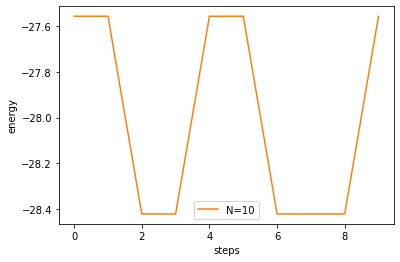

In [15]:
import matplotlib.pyplot as plt

N_atom_1 = 10

#Array to store energy history
energy_hist1 = []

#get random initial position
pos_1 = init_pos(N_atom_1)

#perform basin hopping method
for i in range(N_atom_1):
    res1 = basinhopping(total_energy, pos_1, niter=10, 
                        minimizer_kwargs={'method':'BFGS'},
                       T=0.8, stepsize=2.0, disp=False)
    new1 = res1.fun
    energy_hist1.append(new1)
    
ground_state_1 = get_pos_from_url(N=10)
print('Ground State for N=10:', total_energy(ground_state_1))
    
#Make plot of energy evolution as a function of steps
plt.plot(total_energy(ground_state_1), '-')
plt.plot(energy_hist1, label='N=10')
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy')
plt.show()

Ground State for N=20: -77.17704248805858


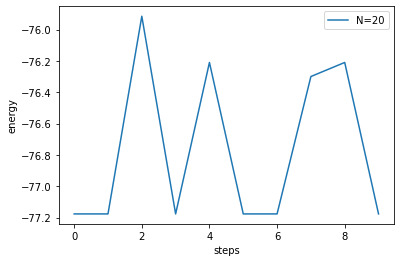

In [16]:
N_atom_2 = 20
energy_hist2 = []
pos_2 = init_pos(N_atom_2)

for i in range(10):
    res2 = basinhopping(total_energy, pos_2, niter=15,
                        minimizer_kwargs={'method':'L-BFGS-B'},
                       T=3.5, stepsize=0.5, disp=False)
    new2 = res2.fun
    energy_hist2.append(new2)
    
ground_state_2 = get_pos_from_url(N=20)
print('Ground State for N=20:', total_energy(ground_state_2))

plt.plot(energy_hist2, label='N=20')
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy')
plt.show()

Ground State for N=30: -128.28657056294892


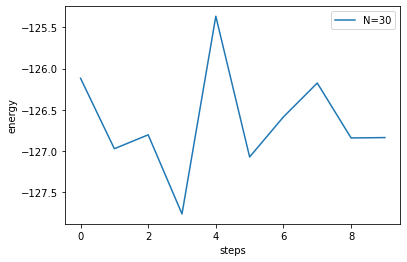

In [17]:
N_atom_3 = 30
energy_hist3 = []
pos_3 = init_pos(N_atom_3)

for i in range(10):
    res3 = basinhopping(total_energy, pos_3, niter=15,
                        minimizer_kwargs={'method':'L-BFGS-B'},
                       T=18.5, stepsize=0.6, disp=False)
    new3 = res3.fun
    energy_hist3.append(new3)
    
ground_state_3 = get_pos_from_url(N=30)
print('Ground State for N=30:', total_energy(ground_state_3))

plt.plot(energy_hist3, label='N=30')
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy')
plt.show()